# Figure 2
- Identify TFs that target adhesome loci
- Study their activity and proximity in Hi-C

### Setup

In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
# Custom libraries
import utils as lu
# Reload modules in case of modifications
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/figures0/utils.py'>

In [2]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Import TF data

In [4]:
# Load TF-target data (TRRUST)
tf_df = pickle.load(open(dir_genome+'trrust_df.pkl', 'rb'))
all_tf_genes = np.unique(tf_df['TF'].values)
tf_df.head()

,TF,Target,Regulation,PMID
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


In [5]:
# Load all/active/inactive loci
all_loci = pickle.load(open(saving_dir+'all_loci.pkl', 'rb'))
active_loci = pickle.load(open(saving_dir+'active_loci.pkl', 'rb'))
inactive_loci = pickle.load(open(saving_dir+'inactive_loci.pkl', 'rb'))

### Identify TFs that target adhesome genes

In [6]:
# Load all/active/inactive adhesome loci and genes
adhesome_loci_list = pickle.load(open(saving_dir+'adhesome_loci_list.pkl', 'rb'))
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
adhesome_genes_list = pickle.load(open(saving_dir+'adhesome_genes.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl', 'rb'))
# Load all active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))

In [7]:
# TFs targeting adhesome loci
tf_adhesome_df = tf_df[tf_df['Target'].isin(adhesome_genes_list)]
tf_adhesome_df['is_target_active'] = [(target in active_adhesome_genes) for target in tf_adhesome_df['Target'].values]
tf_targeting_adhesome = np.unique(tf_adhesome_df['TF'].values)
tf_targeting_active_adhesome = np.unique(tf_adhesome_df[tf_adhesome_df['Target'].isin(active_adhesome_genes)]['TF'].values)
tf_targeting_inactive_adhesome = np.unique(tf_adhesome_df[tf_adhesome_df['Target'].isin(inactive_adhesome_genes)]['TF'].values)
print('Number of TFs targeting adhesome genes = '+str(len(tf_targeting_adhesome)))
print('TFs targeting adhesome genes that are themselves adhesome genes = '+str(set(tf_targeting_adhesome).intersection(set(adhesome_genes_list))))
print('Number of TFs targeting active adhesome genes = '+str(len(tf_targeting_active_adhesome)))
print('Number of TFs targeting inactive adhesome genes = '+str(len(tf_targeting_inactive_adhesome)))
tf_adhesome_df.head()

Number of TFs targeting adhesome genes = 128
TFs targeting adhesome genes that are themselves adhesome genes = {'STAT3'}
Number of TFs targeting active adhesome genes = 124
Number of TFs targeting inactive adhesome genes = 13


,TF,Target,Regulation,PMID,is_target_active
48,APC,AKT1,Repression,15888491,True
69,AR,AKT1,Activation_Repression,11278645;20589722,True
133,AR,PTEN,Activation_Unknown,23418309;20729295;21532617,True
135,AR,PTPN1,Unknown,22282656,True
156,AR,VIM,Repression,18535113,True


### Regulation effects of adhesome-targeting loci

<Figure size 432x288 with 0 Axes>

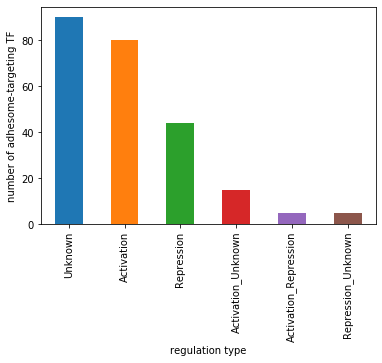

In [8]:
# Plot regulation type of adhesome TFs
plt.figure()
tf_adhesome_df.groupby('Regulation').count().reset_index().sort_values(by='Target', ascending=False).plot.bar(x='Regulation', y='Target', legend=None)
plt.xlabel('regulation type')
plt.ylabel('number of adhesome-targeting TF')
plt.show()

### Find the loci corresponding to adhesome-targeting TFs

In [9]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)

In [10]:
# Datframe with TF names
df_components = pd.DataFrame({'geneSymbol': tf_targeting_adhesome})
df_components.head()

,geneSymbol
0,APC
1,AR
2,ATF1
3,ATF2
4,ATM


In [11]:
# Find location of adhesome-targeting TF genes
tf_loc_df, missing_tf_genes = lu.get_adhesome_genes_location(df_components, df_loc)
tf_loc_df = lu.get_adhesome_genes_loci(tf_loc_df, resol)
tf_loc_df['chrom_int'] = tf_loc_df['chrom'].str.split('chr').str[1].astype(int)
tf_genes = np.unique(tf_loc_df['gene'])
print('Final number of TF genes = '+str(len(tf_genes)))
# Construct data frame annotating each adhesome locus with gene
tf_chr_loci = tf_loc_df[['chrom','chrom_int','loci','gene']]
tf_chr_loci = tf_chr_loci.sort_values(['chrom_int','loci'])
tf_loci = [tf_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(tf_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(tf_chr_loci))]
# Add locus ID column
tf_chr_loci['locus_id'] = ['chr_'+str(tf_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(tf_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(tf_chr_loci))]
# Visualize head of adhesome_chr_loci
print('Number of TF loci = '+str(len(tf_loci)))
tf_chr_loci.head()

Adhesome genes absent from UCSC genes: ['KLF8', 'AR', 'TAF1']
Final number of TF genes = 125
Number of TF loci = 160


,chrom,chrom_int,loci,gene,locus_id
90,chr1,1,8,SKI,chr_1_loc_2000000
14,chr1,1,39,CTNNBIP1,chr_1_loc_9750000
86,chr1,1,100,RUNX3,chr_1_loc_25000000
86,chr1,1,101,RUNX3,chr_1_loc_25250000
34,chr1,1,131,HDAC1,chr_1_loc_32750000


In [12]:
# List of all adhesome-targeting TFs
tfs_targeting_adhesome_genes = np.unique(tf_chr_loci['gene'].values)
pickle.dump(tfs_targeting_adhesome_genes ,open(saving_dir+'tfs_targeting_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
tfs_targeting_adhesome_loci = np.unique(tf_chr_loci['locus_id'].values)
pickle.dump(tfs_targeting_adhesome_loci ,open(saving_dir+'tfs_targeting_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Add TF activity to tf_adhesome_df
tf_adhesome_df = tf_adhesome_df[~tf_adhesome_df['TF'].isin(['KLF8', 'TAF1', 'AR'])]
tf_adhesome_df['is_tf_active'] = [(tf_chr_loci[tf_chr_loci['gene']==tf]['locus_id'].values[0] in all_active_loci) for tf in tf_adhesome_df['TF'].values]
tf_adhesome_df.head()

,TF,Target,Regulation,PMID,is_target_active,is_tf_active
48,APC,AKT1,Repression,15888491,True,True
228,ATF1,PLAUR,Unknown,12369939,True,True
250,ATF2,ITGB8,Unknown,21878622,True,True
358,ATM,PVR,Activation_Repression,21406724;21406724,True,True
396,BCL6,STAT3,Unknown,17951530,True,True


### Add RNAseq information for each locus

In [14]:
# Load tf_loc
tf_loc = pickle.load(open(saving_dir+'tf_loc.pkl', 'rb'))
tf_loc.head()

,gene,chrom,start,end,length,RNAseq,normRNAseq
44,SKI,chr1,2160133,2241652,81519,457,8.631781
1451,CTNNBIP1,chr1,9908333,9970316,61983,363,8.675469
1566,RUNX3,chr1,25226001,25256770,30769,12,5.968715
292,HDAC1,chr1,32757707,32799224,41517,2634,11.057927
1673,MTF1,chr1,38275238,38325292,50054,254,8.532184


In [15]:
# Add RNAseq information to tf_adhesome_df
tf_adhesome_df['tfRNAseq'] = [tf_loc[tf_loc['gene']==tf]['normRNAseq'].values[0] for tf in tf_adhesome_df['TF'].values]
tf_adhesome_df.head()

,TF,Target,Regulation,PMID,is_target_active,is_tf_active,tfRNAseq
48,APC,AKT1,Repression,15888491,True,True,9.395377
228,ATF1,PLAUR,Unknown,12369939,True,True,8.781036
250,ATF2,ITGB8,Unknown,21878622,True,True,8.586265
358,ATM,PVR,Activation_Repression,21406724;21406724,True,True,8.340918
396,BCL6,STAT3,Unknown,17951530,True,True,8.397621


<Figure size 432x288 with 0 Axes>

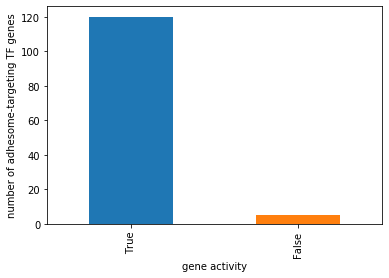

In [16]:
# Plot activity of adhesome-targeting TF genes
plt.figure()
tf_adhesome_df.drop_duplicates('TF').groupby('is_tf_active').count()
tf_adhesome_df.drop_duplicates('TF').groupby('is_tf_active').count().reset_index().sort_values(by='TF', ascending=False).plot.bar(x='is_tf_active', y='TF', legend=None)
plt.xlabel('gene activity')
plt.ylabel('number of adhesome-targeting TF genes')
plt.show()

In [17]:
# Restrict tf_adhesome_df to active TFs with active targets
tf_adhesome_df1 = tf_adhesome_df[(tf_adhesome_df['is_target_active']==True) & (tf_adhesome_df['is_tf_active']==True)]

In [18]:
# Create list of activating and repressing active TFs targeting active adhesome genes
activating_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Activation']['TF'].values)
repressing_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Repression']['TF'].values)
unknown_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Unknown']['TF'].values)
print('Number of activating TFs = '+str(len(activating_tfs)))
print('Number of repressing TFs = '+str(len(repressing_tfs)))
print('Number of activating-only TFs = '+str(len(set(activating_tfs)-set(repressing_tfs))))
print('Number of repressing-only TFs = '+str(len(set(repressing_tfs)-set(activating_tfs))))

Number of activating TFs = 46
Number of repressing TFs = 37
Number of activating-only TFs = 36
Number of repressing-only TFs = 27


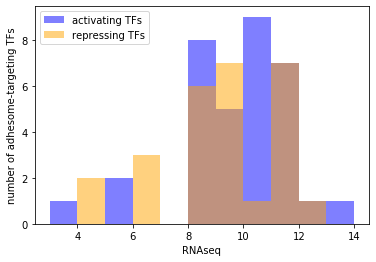

In [19]:
# Distribution of RNAseq among activating and repressing adhesome-targeting TFs
plt.figure()
plt.hist(tf_loc[tf_loc['gene'].isin(set(activating_tfs)-set(repressing_tfs))]['normRNAseq'].values, 
         bins=np.arange(3,15,1), color='blue', alpha=0.5, label='activating TFs')
plt.hist(tf_loc[tf_loc['gene'].isin(set(repressing_tfs)-set(activating_tfs))]['normRNAseq'].values, 
         bins=np.arange(3,15,1), color='orange', alpha=0.5, label='repressing TFs')
#plt.hist(tf_loc[tf_loc['gene'].isin(set(unknown_tfs)-set(activating_tfs)-set(repressing_tfs))]['normRNAseq'].values, 
#         bins=np.arange(0,15,1), color='green', alpha=0.5, label='unknown TFs')
plt.xlabel('RNAseq')
plt.ylabel('number of adhesome-targeting TFs')
plt.legend()
plt.show()

<span class="mark">TODO:
- <span class="mark">On this plot, select all TFs having RNAseq>8</span>
- <span class="mark">Look at the RNAseq expression of their targets (one blue histogram for activating TFs, and orange one for repressing TFs)</span>
- <span class="mark">Our guess is that there will be no difference, i.e. the TFs are not very well annotated in the database</span>

### Proximity of adhesome-targeting TFs in Hi-C

In [20]:
# Create list out of all adhesome and random groups of loci (sorted by chromosome)
tfs_targeting_adhesome_loci = tfs_targeting_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in tfs_targeting_adhesome_loci])]
random_active_non_adhesome_TF_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_TF_loci.pkl', 'rb')))
random_active_non_adhesome_TF_loci = random_active_non_adhesome_TF_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_TF_loci])]
loci_list = list(itertools.chain.from_iterable([tfs_targeting_adhesome_loci,
                                                random_active_non_adhesome_TF_loci]))

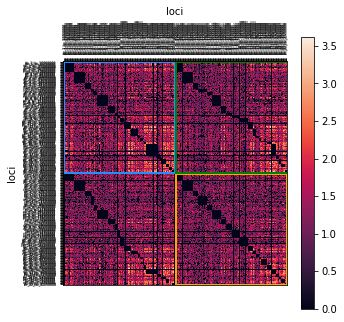

In [22]:
# Load contacts_df1_tf
contacts_df1_tf = pickle.load(open(saving_dir+'contacts_df1_tf.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(tfs_targeting_adhesome_loci)-1, len(tfs_targeting_adhesome_loci)-1,'dodgerblue'],
                [len(tfs_targeting_adhesome_loci)+1,len(tfs_targeting_adhesome_loci)+1,len(random_active_non_adhesome_TF_loci)-1,len(random_active_non_adhesome_TF_loci)-1,'orange'],
                [len(tfs_targeting_adhesome_loci)+1, 0,len(random_active_non_adhesome_TF_loci),len(tfs_targeting_adhesome_loci)-1,'green']]
lu.plot_heatmap(contacts_df1_tf, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1_tf.max().max(), add_patches = patches_list)

Note: There is no fundamental difference between the four quadrants. Note that in all quadrants, there seems to be higher HiC contact among the last few chromosomes. We showed that there is in general a higher contact betwen the last chromosomes in Figure 1.

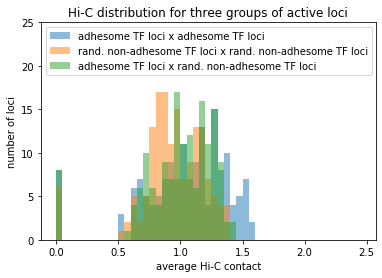

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=3.717739109296632, pvalue=0.0002010136991599096)


In [23]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with itself
active_adhesome_tf_hic_with_itself = contacts_df1_tf.loc[tfs_targeting_adhesome_loci,tfs_targeting_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with itself
random_active_adhesome_TF_hic_with_itself = contacts_df1_tf.loc[random_active_non_adhesome_TF_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_TF_active = contacts_df1_tf.loc[tfs_targeting_adhesome_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_itself, 
         bins=np.arange(0,2.5,0.05), alpha=0.5, density=False, label='adhesome TF loci x adhesome TF loci')
plt.hist(random_active_adhesome_TF_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='rand. non-adhesome TF loci x rand. non-adhesome TF loci')
plt.hist(random_versus_adhesome_TF_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x rand. non-adhesome TF loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,25)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_tf_hic_with_itself.values,
                  random_active_adhesome_TF_hic_with_itself))

### Proximity of adhesome-targeting TFs and adhesome genes in Hi-C

In [24]:
# Load active adhesome loci and active random loci
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
random_active_non_adhesome_loci = pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb'))

In [25]:
# Order loci list by chromosome
tfs_targeting_adhesome_loci = tfs_targeting_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in tfs_targeting_adhesome_loci])]
active_adhesome_loci = active_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_adhesome_loci])]
random_active_non_adhesome_TF_loci = random_active_non_adhesome_TF_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_TF_loci])]
# Create list out of all adhesome loci, random loci and adhesome TF loci
loci_list = list(itertools.chain.from_iterable([tfs_targeting_adhesome_loci,
                                                active_adhesome_loci,
                                                random_active_non_adhesome_TF_loci]))

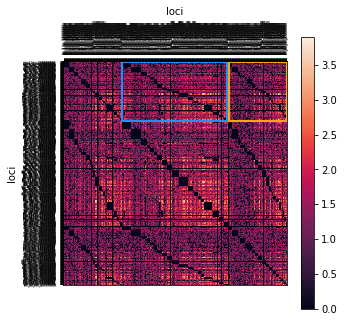

In [54]:
# Load contacts_df2_tf
contacts_df2_tf = pickle.load(open(saving_dir+'contacts_df2_tf.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[len(tfs_targeting_adhesome_loci),1,len(active_adhesome_loci)-2,len(tfs_targeting_adhesome_loci),'dodgerblue'],
                [2+len(tfs_targeting_adhesome_loci)+len(active_adhesome_loci),1,len(random_active_non_adhesome_TF_loci)-1,len(tfs_targeting_adhesome_loci),'orange']]
lu.plot_heatmap(contacts_df2_tf, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df2_tf.max().max(), add_patches=patches_list)
# CHANGE HERE FROM random_active_non_adhesome_TF_loci TO random_active_non_adhesome_loci
# Pick len(active_adhesome_loci) random active loci that are not adhesome

<span class="mark">ToDo</span>
- <span class="mark">Double check that I am really doing what I want in this plot, the orange matrix should have the same size as the blue matrix here, there is an issue!</span>

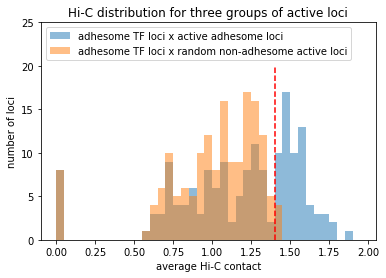

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=5.05885060703613, pvalue=4.2179114512906796e-07)


In [75]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with active adhesome loci
active_adhesome_tf_hic_with_adhesome_loci = contacts_df2_tf.loc[tfs_targeting_adhesome_loci,active_adhesome_loci].mean(axis=1)
# Group of active adhesome TF loci with random active non-adhesome loci
active_adhesome_tf_hic_with_random_loci = contacts_df2_tf.loc[tfs_targeting_adhesome_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_adhesome_loci, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x active adhesome loci')
plt.hist(active_adhesome_tf_hic_with_random_loci, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x random non-adhesome active loci')
plt.vlines(x=1.4, ymin=0, ymax=20, color='red', linestyle='dashed')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,25)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_tf_hic_with_adhesome_loci.values,
                  active_adhesome_tf_hic_with_random_loci))

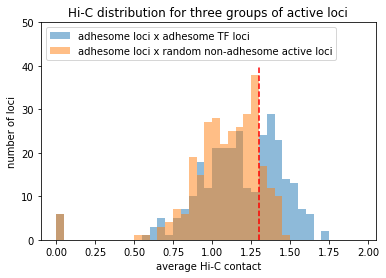

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=5.05885060703613, pvalue=4.2179114512906796e-07)


In [81]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with active adhesome loci
adhesome_loci_with_active_adhesome_tf = contacts_df2_tf.loc[active_adhesome_loci,tfs_targeting_adhesome_loci].mean(axis=1)
# Group of active adhesome TF loci with random active non-adhesome loci
adhesome_loci_with_random_loci = contacts_df2_tf.loc[active_adhesome_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(adhesome_loci_with_active_adhesome_tf, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome TF loci')
plt.hist(adhesome_loci_with_random_loci, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x random non-adhesome active loci')
plt.vlines(x=1.3, ymin=0, ymax=40, color='red', linestyle='dashed')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,50)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_tf_hic_with_adhesome_loci.values,
                  active_adhesome_tf_hic_with_random_loci))

<span class="mark">ToDo</span>
- <span class="mark">Do the same histogram plots as above, except that now do not take the mean over all adhesome loci, but do teh histogram of all HiC values in the blue matrix</span>
- <span class="mark">Select the top of these values and the TF/adhesome loci they correspond to</span>
- <span class="mark">Use these to build a subgraph</span>

### Analyze densely connected adhesome TFs
- We select all TF loci that have average HiC contact with adhesome loci higher than 1.4
- Select all adhesome loci that have average HiC contact with TF loci higher than 1.3
- We construct a network among these selected TF loci and selected adhesome loci
- We put a threshold on HiC value and return the final network

In [164]:
# Select TF loci
avg_hic_with_adhesome = contacts_df2_tf.loc[tfs_targeting_adhesome_loci,active_adhesome_loci].mean(axis=1)
selected_tf_loci = avg_hic_with_adhesome.index.values[np.where(avg_hic_with_adhesome.values>1.4)]
print('Total number of selected TF loci = '+str(len(selected_tf_loci)))
# Select adhesome loci
avg_hic_with_tfs = contacts_df2_tf.loc[active_adhesome_loci,tfs_targeting_adhesome_loci].mean(axis=1)
selected_adhesome_loci = avg_hic_with_tfs.index.values[np.where(avg_hic_with_tfs.values>1.3)]
print('Total number of selected adhesome loci = '+str(len(selected_adhesome_loci)))
# All selected loci
all_selected_loci = np.unique(list(itertools.chain.from_iterable([selected_tf_loci,selected_adhesome_loci])))
print('Total number of selected loci = '+str(len(all_selected_loci)))

Total number of selected TF loci = 63
Total number of selected adhesome loci = 118
Total number of selected loci = 155


<span class="mark">ToDo</span>
- <span class="mark">Output the list of 63 TFs that are important (still using the mean HiC over adhesome genes) ranked by order of importance</span>

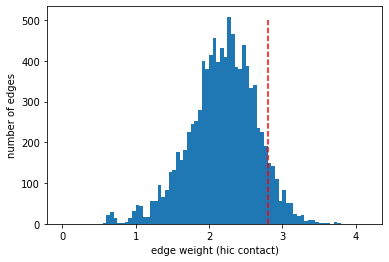

In [165]:
# Adjacency matrix to edge list
adj_mat = contacts_df2_tf.loc[selected_tf_loci,selected_adhesome_loci]
edge_list = adj_mat.stack().reset_index()
edge_list.columns = ['locus1','locus2','hic']
edge_list = edge_list[edge_list['hic']>0]
plt.figure()
plt.hist(edge_list['hic'].values, bins=np.arange(0,4.2,0.05))
plt.vlines(x=2.8, ymin=0, ymax=500, color='red', linestyle='dashed')
plt.xlabel('edge weight (hic contact)')
plt.ylabel('number of edges')
plt.show()

In [166]:
# Put lower threshold on HiC values
edge_list = edge_list[edge_list['hic']>2.8]
edge_list['vertex_set'] = [str(np.sort([edge_list.iloc[i]['locus1'], edge_list.iloc[i]['locus2']])) for i in range(len(edge_list))]
edge_list = edge_list.drop_duplicates(subset=['vertex_set'])
print('Total number of edges = '+str(len(edge_list)))

Total number of edges = 386


In [167]:
# Create network
network = nx.from_pandas_edgelist(edge_list, 'locus1', 'locus2', ['hic'])
print('Total number of nodes in network = '+str(len(network.nodes)))
print('Total number of edges in network = '+str(len(network.edges)))
print('Average node degree in network = '+str(np.mean(list(dict(network.degree).values()))))
print('Number of connected components in network = '+str(nx.number_connected_components(network)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(network)]))
print('Distribution of edge weights')

Total number of nodes in network = 113
Total number of edges in network = 386
Average node degree in network = 6.831858407079646
Number of connected components in network = 1
Size of connected components = [113]
Distribution of edge weights


In [168]:
# For each locus, also express it by the corresponding genes
adhesome_gene_id_ls = []
tf_gene_id_ls = []
locus_gene_list = []
locus_adhesome_gene_list = []
locus_tf_gene_list = []
for locus in tqdm(list(network.nodes)):
    time.sleep(.01)
    # Select chromosome
    chrom = 'chr'+locus.split('_')[1]
    df_loc_chrom = df_loc[df_loc['#chrom']==chrom]
    # Find genes and create gene ID for the locus
    loc = int(locus.split('_')[3])
    genes0 = df_loc_chrom.loc[(df_loc_chrom['chromStart']//resol)*resol == loc,'geneSymbol'].values
    genes1 = df_loc_chrom.loc[(df_loc_chrom['chromEnd']//resol)*resol == loc,'geneSymbol'].values
    genes2 = df_loc_chrom.loc[((df_loc_chrom['chromStart']//resol)*resol < loc) & 
                             ((df_loc_chrom['chromEnd']//resol)*resol > loc),'geneSymbol'].values
    genes = np.unique(list(itertools.chain.from_iterable([genes0,genes1,genes2])))
    adhesome_genes = [gene for gene in genes if gene in adhesome_genes_list]
    tf_genes = [gene for gene in genes if gene in tfs_targeting_adhesome_genes]
    locus_gene_list.append(genes)
    locus_adhesome_gene_list.append(adhesome_genes)
    locus_tf_gene_list.append(tf_genes)
    adhesome_gene_id = ''+"_".join(adhesome_genes)
    tf_gene_id = ''+"_".join(tf_genes)
    adhesome_gene_id_ls.append(adhesome_gene_id)
    tf_gene_id_ls.append(tf_gene_id)

100%|██████████| 113/113 [00:02<00:00, 55.99it/s]


In [172]:
node_attributes = pd.DataFrame({'locus_id': list(network.nodes),
                                'chr': [[int(locus.split('_')[1])] for locus in list(network.nodes)],
                                'adhesome_gene_id': adhesome_gene_id_ls,
                                'tf_gene_id': tf_gene_id_ls,
                                'locus_gene_list': locus_gene_list,
                                'locus_adhesome_gene_list': locus_adhesome_gene_list,
                                'locus_tf_gene_list': locus_tf_gene_list,
                                'has_genes': [len(gene_ls) for gene_ls in locus_gene_list],
                                'has_adhesome_genes': [len(gene_ls) for gene_ls in locus_adhesome_gene_list],
                                'has_tf_genes': [len(gene_ls) for gene_ls in locus_tf_gene_list]})
node_attributes = node_attributes.set_index('locus_id')
node_attributes.head()

,chr,adhesome_gene_id,tf_gene_id,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list,has_genes,has_adhesome_genes,has_tf_genes
locus_id,,,,,,,,,
chr_1_loc_9750000,[1],,CTNNBIP1,"[CLSTN1, CTNNBIP1, LZIC, PIK3CD]",[],[CTNNBIP1],4,0,1
chr_11_loc_750000,[11],CD151,,"[AK126635, AP2A2, AX747537, CD151, CEND1, CHID...",[CD151],[],18,1,0
chr_1_loc_25000000,[1],,RUNX3,"[CLIC4, RUNX3]",[],[RUNX3],2,0,1
chr_8_loc_144750000,[8],PLEC,,"[AX746851, BREA2, CCDC166, EPPK1, FAM83H, LOC1...",[PLEC],[],14,1,0
chr_9_loc_133500000,[9],ABL1,,"[ABL1, AX748265, EXOSC2, FUBP3, PRDM12]",[ABL1],[],5,1,0


In [170]:
# Annotate graph
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'chr'][0]) for locus in network.nodes}, 'chromosome')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'adhesome_gene_id'] for locus in network.nodes}, 'adhesome_gene_id')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'tf_gene_id'] for locus in network.nodes}, 'tf_gene_id')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'adhesome_gene_id']+'_'+node_attributes.loc[locus,'tf_gene_id'] for locus in network.nodes}, 'adh_tf_gene_id')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_genes']) for locus in network.nodes}, 'number_of_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_gene_list'].tolist() for locus in network.nodes}, 'gene_list')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_adhesome_genes']) for locus in network.nodes}, 'number_of_adhesome_genes')
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'has_adhesome_genes']>0) for locus in network.nodes}, 'has_adhesome_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_adhesome_gene_list'] for locus in network.nodes}, 'adhesome_gene_list')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_tf_genes']) for locus in network.nodes}, 'number_of_tf_genes')
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'has_tf_genes']>0) for locus in network.nodes}, 'has_tf_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_tf_gene_list'] for locus in network.nodes}, 'tf_gene_list')

In [171]:
# Save network to html
oi.output_networkx_graph_as_interactive_html(network, filename=saving_dir+"fig2_network.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/fig2_network.html')

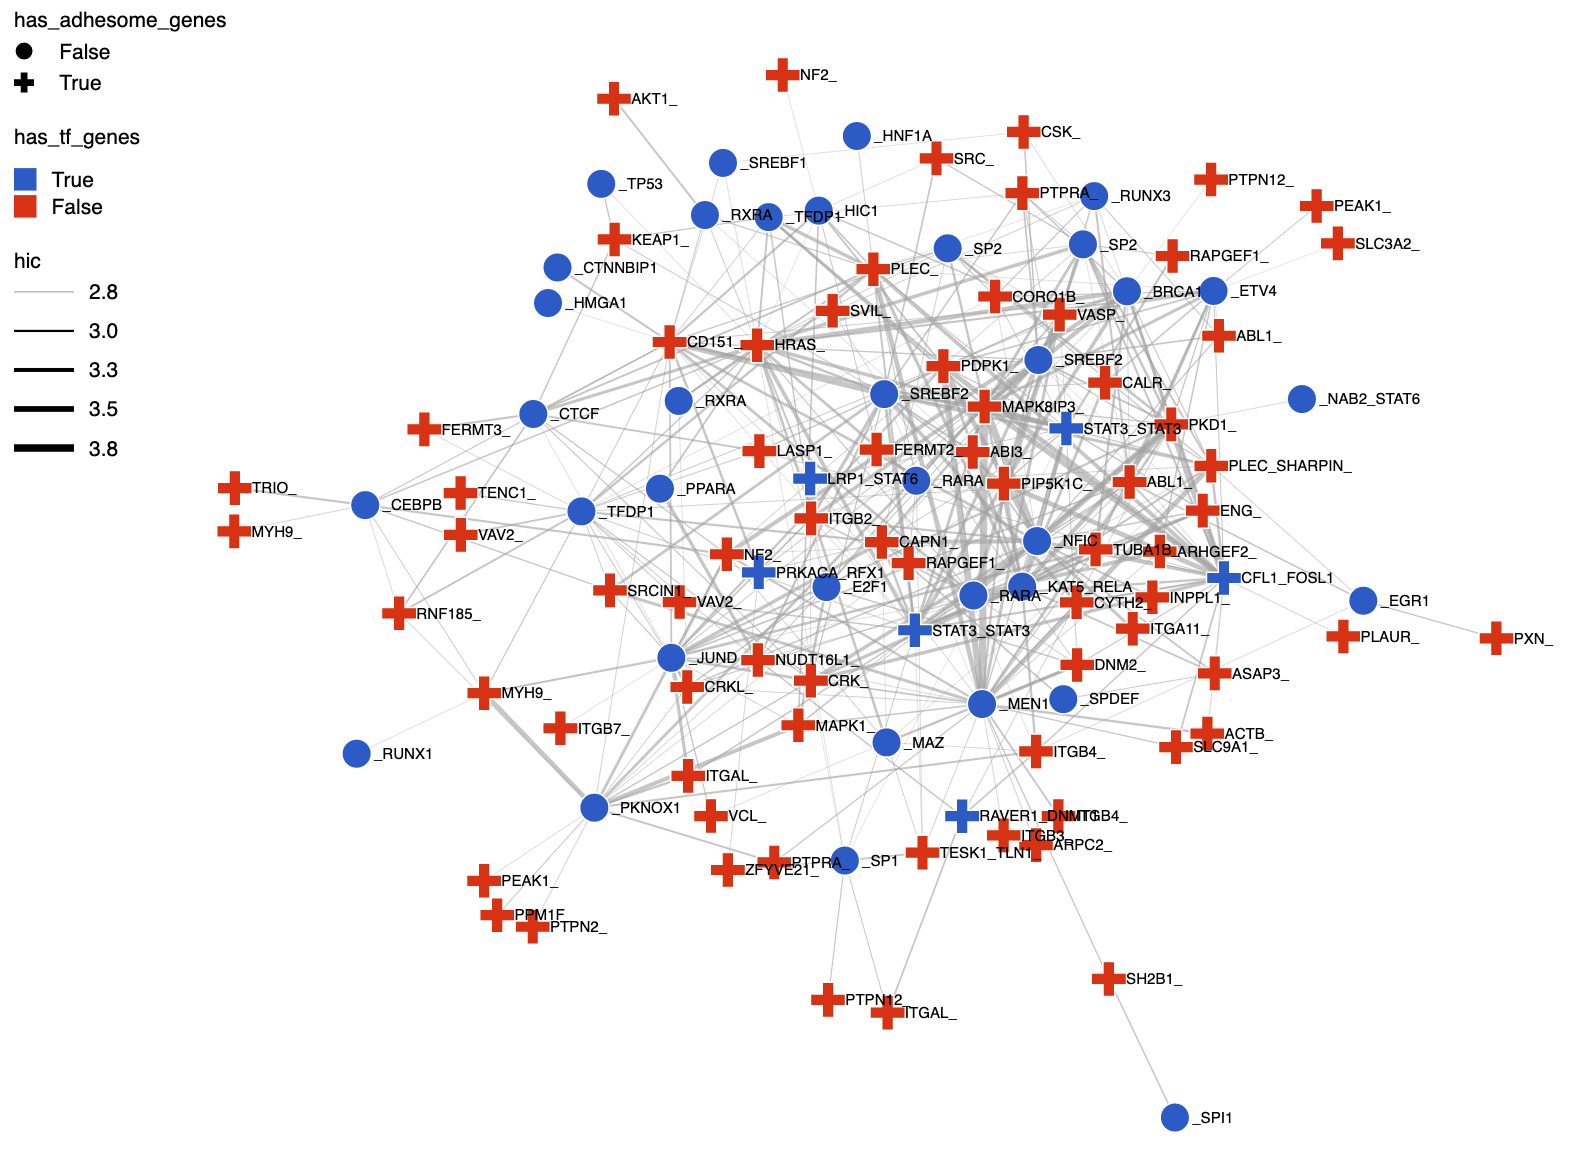

<span class="mark">ToDo</span>
- <span class="mark">Check that this is not a bipartite graph adn that I am adding all the edges required</span>
- <span class="mark">We need to find triangles, so drop all nodes that have degree 1</span>
- <span class="mark">Do clustering (using Louvain or correlation clustering)</span>